In addition to the expected functions to draw one more more molecules, the RDKit `MolDraw2D` objects lets you add annotations (text, lines, arrows, shapes, etc) to your drawings. This post shows how to use that to layout the molecules and data from some free-energy calculations.

The data here and the overall figure layout is from [Figure 8](https://link.springer.com/article/10.1007/s10822-021-00436-z/figures/8) of [this open-access paper](https://link.springer.com/article/10.1007/s10822-021-00436-z) from our group.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 350,300
import rdkit
print(rdkit.__version__)

2024.09.6


Start with the scaffold for the molecules:

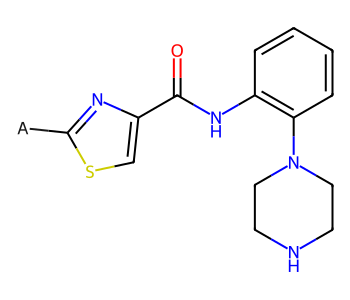

In [2]:
core = Chem.MolFromMolBlock('''
  Mrv2401 03062519142D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 21 23 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -1.8519 5.7623 0 0
M  V30 2 C -3.1855 4.9922 0 0
M  V30 3 C -3.1855 3.4522 0 0
M  V30 4 C -1.8519 2.6822 0 0
M  V30 5 C -0.5182 3.4522 0 0
M  V30 6 C -0.5182 4.9922 0 0
M  V30 7 N -1.8519 1.1422 0 0
M  V30 8 C -3.1855 0.3722 0 0
M  V30 9 C -3.1855 -1.1679 0 0
M  V30 10 N -1.8519 -1.9379 0 0
M  V30 11 C -0.5182 -1.1679 0 0
M  V30 12 C -0.5182 0.3722 0 0
M  V30 13 N -4.5192 2.6822 0 0
M  V30 14 C -5.8529 3.4522 0 0
M  V30 15 C -7.1866 2.6822 0 0
M  V30 16 O -5.8529 4.9922 0 0
M  V30 17 N -8.5934 3.3086 0 0
M  V30 18 C -9.6238 2.1642 0 0
M  V30 19 S -8.8538 0.8305 0 0
M  V30 20 C -7.3476 1.1507 0 0
M  V30 21 A -11.1554 2.3252 0 1
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 4 7
M  V30 8 1 8 9
M  V30 9 1 9 10
M  V30 10 1 10 11
M  V30 11 1 11 12
M  V30 12 1 7 8
M  V30 13 1 7 12
M  V30 14 1 3 13
M  V30 15 1 13 14
M  V30 16 1 14 15
M  V30 17 2 14 16
M  V30 18 1 18 19
M  V30 19 1 19 20
M  V30 20 1 15 17
M  V30 21 2 15 20
M  V30 22 2 17 18
M  V30 23 1 18 21
M  V30 END BOND
M  V30 END CTAB
M  END
''')
core

Now define the side chains:

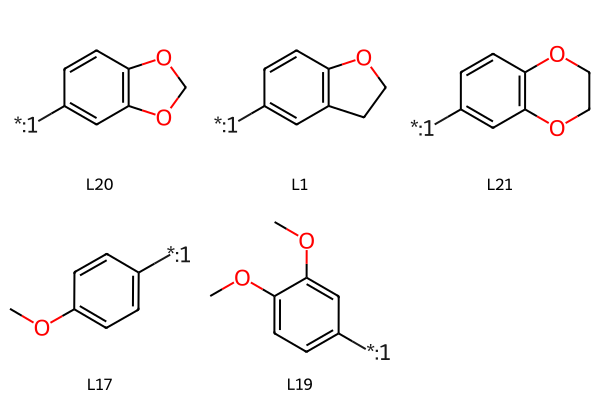

In [3]:
chains = (('L20','[*:1]C1=CC2=C(OCO2)C=C1'),
          ('L1','[*:1]C1=CC2=C(OCC2)C=C1'),
          ('L21','[*:1]C1=CC2=C(OCCO2)C=C1'),
          ('L17', '[*:1]c1ccc(OC)cc1'),
          ('L19', '[*:1]c1ccc(OC)c(OC)c1'),
         )

chainmols = [Chem.MolFromSmiles(y) for x,y in chains]
Draw.MolsToGridImage(chainmols,legends=[x for x,y in chains])

I'd like the side chains to all be oriented consistently, so I'm going to construct the full molecules, lay them out, and then remove the core from each of those.

Here's the easy way to construct the full molecules, using `Chem.molzip()`

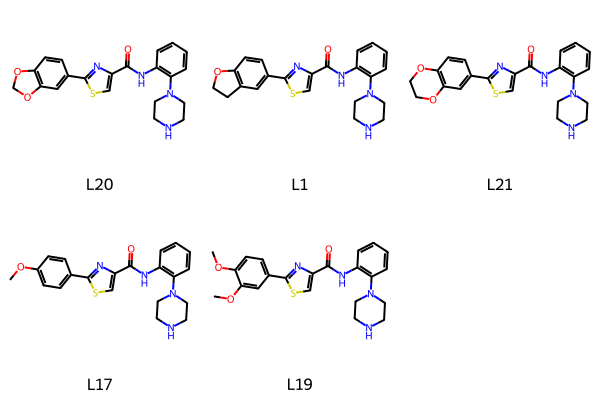

In [4]:
mols = []
for lbl,smi in chains:
    nm = Chem.molzip(core,Chem.MolFromSmiles(smi))
    rdDepictor.Compute2DCoords(nm)
    mols.append(nm)
    
Draw.MolsToGridImage(mols,legends = [x for x,y in chains])

Now use `Chem.ReplaceCore()` to remove the core atoms from each molecule, leaving us with just the sidechains in a consistent orientation:

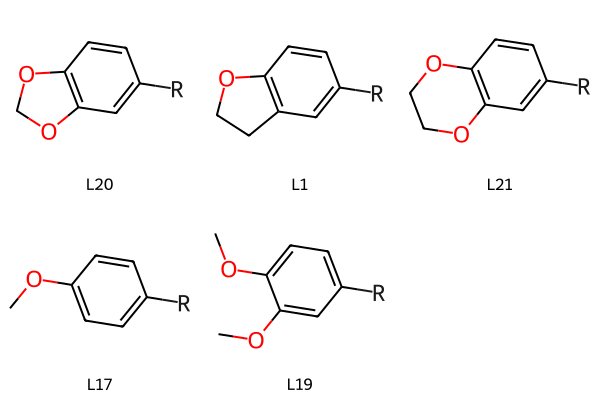

In [5]:
justcore = Chem.RWMol(core)
# We need to remove the dummy atom:
justcore.RemoveAtom(20)

newchains = {}
for (lbl,smi),mol in zip(chains,mols):
    tmol = Chem.ReplaceCore(mol,justcore)
    # label the dummy atom:
    for atom in tmol.GetAtoms():
        if not atom.GetAtomicNum():
            atom.SetProp('atomLabel',"R")
    newchains[lbl] = tmol

Draw.MolsToGridImage(newchains.values(), legends=newchains.keys())

The easiest way to reproduce the target figure is by laying the molecules out on a 3x3 grid with some empty spaces:

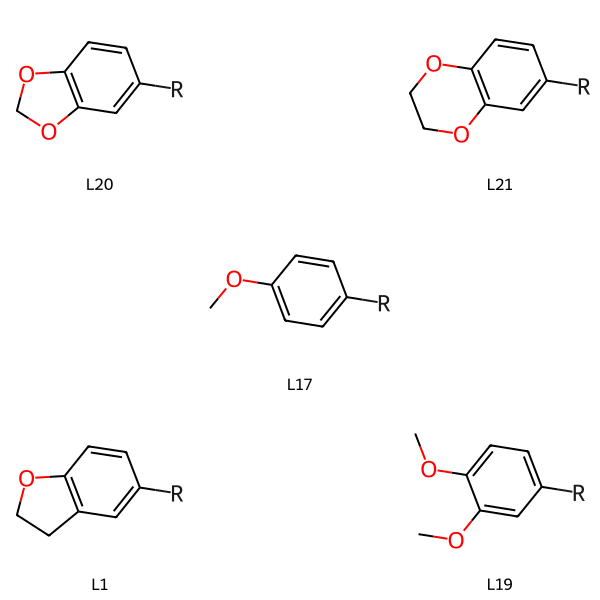

In [6]:
lbls = ['L20','','L21',
        '','L17','',
        'L1','','L19']
grid = [newchains[l] if l else None for l in lbls]
Draw.MolsToGridImage(grid,legends=lbls)

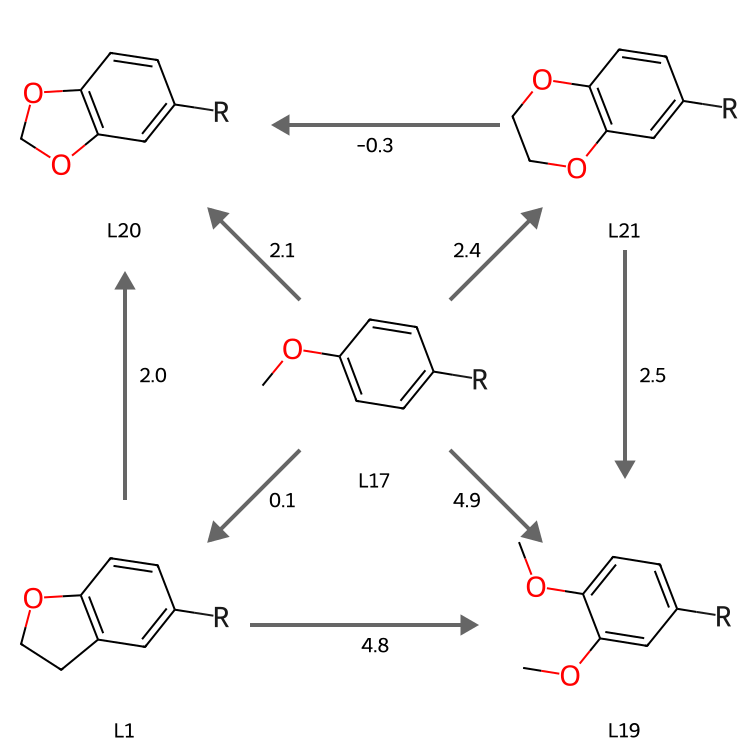

In [7]:
from IPython.display import SVG
from rdkit import Geometry

# set up the drawing object:
nRows = 3
nCols = 3
panelx = 250
panely = 250
d2d = Draw.MolDraw2DSVG(panelx*nCols,panely*nRows,panelx,panely)
dopts = d2d.drawOptions()
dopts.legendFontSize = 20

# draw the sidechains
d2d.DrawMolecules(grid,legends=lbls)

# Now draw all the arrows and add the free-energy values
d2d.SetLineWidth(4)
d2d.SetFontSize(20)

# use gray arrows so that they don't stand out quite so much
#   (the original figure has solid black, but I find this nicer)
arrowColor = (.4,.4,.4)

p1 = Geometry.Point2D(panelx,panely/2)
p2 = Geometry.Point2D(2*panelx,panely/2)
d2d.DrawArrow(p2,p1,color=arrowColor,rawCoords=True, asPolygon=True)

# draw the free-energy value slightly offset along the y axis
# (this is a horizontal arrow) from the mid-point of the arrow:
midp = p2 + (p1-p2)/2
midp.y += 20
d2d.DrawString("-0.3",midp,rawCoords=True)


p1 = Geometry.Point2D(panelx/2,panely)
p2 = Geometry.Point2D(panelx/2,2*panely)
d2d.DrawArrow(p2,p1,color=arrowColor,rawCoords=True, asPolygon=True)
midp = p2 + (p1-p2)/2
midp.x += 20
d2d.DrawString("2.0",midp,rawCoords=True, align=1)

p1 = Geometry.Point2D(panelx,2*panely+panely/2)
p2 = Geometry.Point2D(2*panelx,2*panely+panely/2)
d2d.DrawArrow(p1,p2,color=arrowColor,rawCoords=True, asPolygon=True)
midp = p2 + (p1-p2)/2
midp.y += 20
d2d.DrawString("4.8",midp,rawCoords=True)

p1 = Geometry.Point2D(2*panelx + panelx/2,panely)
p2 = Geometry.Point2D(2*panelx + panelx/2,2*panely)
d2d.DrawArrow(p1,p2,color=arrowColor,rawCoords=True, asPolygon=True)
midp = p2 + (p1-p2)/2
midp.x += 20
d2d.DrawString("2.5",midp,rawCoords=True, align=1)

# do the diagonals... these are trickier

# this is the fraction of the side length of the grid boxes that the arrows
# will extend into each box.
frac = 0.2

p1 = Geometry.Point2D((1-frac)*panelx,(1-frac)*panely)
p2 = Geometry.Point2D((1+frac)*panelx,(1+frac)*panely)
d2d.DrawArrow(p2,p1,color=arrowColor,rawCoords=True, asPolygon=True,frac = 0.1)
midp = p2 + (p1-p2)/2
midp.x += 25
d2d.DrawString("2.1",midp,rawCoords=True, align=1)

p1 = Geometry.Point2D((2+frac)*panelx,(1-frac)*panely)
p2 = Geometry.Point2D((2-frac)*panelx,(1+frac)*panely)
d2d.DrawArrow(p2,p1,color=arrowColor,rawCoords=True, asPolygon=True,frac = 0.1)
midp = p2 + (p1-p2)/2
midp.x -= 25
d2d.DrawString("2.4",midp,rawCoords=True, align=2)

p1 = Geometry.Point2D((2+frac)*panelx,(2+frac)*panely)
p2 = Geometry.Point2D((2-frac)*panelx,(2-frac)*panely)
d2d.DrawArrow(p2,p1,color=arrowColor,rawCoords=True, asPolygon=True,frac = 0.1)
midp = p2 + (p1-p2)/2
midp.x -= 25
d2d.DrawString("4.9",midp,rawCoords=True, align=2)

p1 = Geometry.Point2D((1-frac)*panelx,(2+frac)*panely)
p2 = Geometry.Point2D((1+frac)*panelx,(2-frac)*panely)
d2d.DrawArrow(p2,p1,color=arrowColor,rawCoords=True, asPolygon=True,frac = 0.1)
midp = p2 + (p1-p2)/2
midp.x += 25
d2d.DrawString("0.1",midp,rawCoords=True, align=1)


d2d.FinishDrawing()
svg = d2d.GetDrawingText()
SVG(svg)

At the moment it's not possible to change the font colour used for `DrawText()`, so I can't sensibly add the predicted free energy values to the plot. I will fix that for the next RDKit release and update this post at some point in the future once that has been done.

If you're doing a figure for a paper and you want to so some fine tuning of the result, it's almost definitely faster (and likely better) to save the SVG to a file and then use your favorite drawing package that can open SVG files (inkscape, Adobe Illustrator, whatever) to do the final polishing.